<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Векториризация-TF-IDF" data-toc-modified-id="Векториризация-TF-IDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Векториризация TF-IDF</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Pipeline+OptunaSearch" data-toc-modified-id="Pipeline+OptunaSearch-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Pipeline+OptunaSearch</a></span></li><li><span><a href="#Ембеддинги-BERT" data-toc-modified-id="Ембеддинги-BERT-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Ембеддинги BERT</a></span></li><li><span><a href="#Обучение-моделeй-на-эмбеддингах-BERT" data-toc-modified-id="Обучение-моделeй-на-эмбеддингах-BERT-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Обучение моделeй на эмбеддингах BERT</a></span><ul class="toc-item"><li><span><a href="#модель-LogisticRegression" data-toc-modified-id="модель-LogisticRegression-2.3.3.1"><span class="toc-item-num">2.3.3.1&nbsp;&nbsp;</span>модель LogisticRegression</a></span></li><li><span><a href="#модель-Модель--LGBMClassifier-из-библиотеки--LightGBM." data-toc-modified-id="модель-Модель--LGBMClassifier-из-библиотеки--LightGBM.-2.3.3.2"><span class="toc-item-num">2.3.3.2&nbsp;&nbsp;</span>модель Модель  LGBMClassifier из библиотеки  LightGBM.</a></span></li><li><span><a href="#Тестирование-лучшей-модели:" data-toc-modified-id="Тестирование-лучшей-модели:-2.3.3.3"><span class="toc-item-num">2.3.3.3&nbsp;&nbsp;</span>Тестирование лучшей модели:</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# "ВикиФильтр: Система автоматической модерации пользовательских правок"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [5]:
!pip install -q spacy
!pip install -q nltk

!pip install -q torch 
!pip install -q transformers 


In [6]:
!pip install --upgrade -q scikit-learn==1.4.1.post1

!pip install -q lightgbm
!pip install -q optuna
!pip install -q optuna-integration

In [1]:
# импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns



import scipy.stats as st
import numpy as np
import scipy as sp
import math
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import  LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import(f1_score)

import optuna
from optuna.integration import OptunaSearchCV 
from optuna import distributions

from lightgbm import LGBMClassifier

import torch
from transformers import BertTokenizer, BertModel

import logging
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключить вывод optunaSearchCV 
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning) # предупреждения optuna.exceptions off.
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) # предупреждение сходимости моделей

warnings.filterwarnings("ignore", category=UserWarning)# предупреждение о несоответствии стоп-слов в TfidfVectorizer

warnings.filterwarnings('ignore', category=RuntimeWarning, module='optuna_integration')
    

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import notebook 


RANDOM_STATE = 50

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [2]:
# Загрузим необходимые модули и ресурсы из библиотеки NLTK 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dmitr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
# # Загрузим необходимые модули и ресурсы из библиотеки spacy 
import spacy
# Загрузка модели
if 'en_core_web_sm' not in spacy.util.get_installed_models():
    print(' Загрузка модели "en_core_web_sm". \n После загрузки перезапустите ядро!!!\n')
    spacy.cli.download("en_core_web_sm")
else:
    print('Модель "en_core_web_sm" уже установлена.\n')   

print(f'список моделей spacy: {spacy.util.get_installed_models()}\n')

# Получение пути к каталогу данных spaCy
data_path = spacy.util.get_package_path("en_core_web_sm")
print("Путь к каталогу данных spaCy:", data_path)


Модель "en_core_web_sm" уже установлена.

список моделей spacy: ['en_core_web_sm']

Путь к каталогу данных spaCy: C:\Users\dmitr\anaconda3\envs\practicum_pr10\lib\site-packages\en_core_web_sm


Загрузим данные из `toxic_comments.csv` и ознакомимся  сними:

In [5]:
try:
    df_comments = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df_comments = pd.read_csv('toxic_comments.csv')

In [4]:
df_comments.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Удалим столбец `Unnamed: 0`

In [5]:
df_comments.drop('Unnamed: 0', inplace= True, axis=1)

In [6]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
print(f'memory usage:{round(df_comments.memory_usage(deep=True).sum()/(1024*1024),2)} MB')


memory usage:79.88 MB


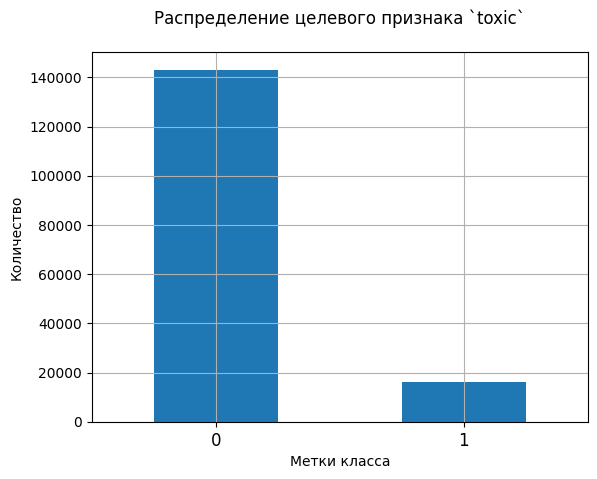

In [8]:
df_comments['toxic'].value_counts().plot(kind='bar',
                                        xlabel='Метки класса',
                                        ylabel='Количество',
                                        grid=True)
plt.gca().tick_params(axis='x', rotation=0, labelsize=12)
plt.gca().set_title('Распределение целевого признака `toxic`', pad=20)
plt.show()

В данных наблюдается дисбаланс классов, этот факт необходимо учитывать при формировании тестовых  и обучающих выборок.

Проверим столбец `text` на русские буквы в тексте:

In [9]:
df_comments[df_comments['text'].str.contains(r'[А-Яа-яёЁ]', regex=True)].shape


(259, 2)

259 строк в столбце 'text', содержат символы русской кириллицы, что составляет менее 0.2% общего массива данных. Для дальнейшей обработки условимся считать тексты англоязычными по семантике и использовать соответствующие модули и библиотеки для работы с английским языком.

Очистим текст, оставив латиницу и пробелы с помощью функции **clear_text**.

In [10]:
# Функция clear_text оставит в тексте только латиницу и пробелы 

def clear_text (text):
    cleaned_text = re.sub(r'[^a-zA-Z. ]', '', text)
    cleaned_text = cleaned_text.split()
    cleaned_text= ' '.join(cleaned_text)
    return cleaned_text

In [11]:
df_comments['text'] = df_comments['text'].apply(clear_text)

Из исходного датасета будет выделена тренировочная выборка размером 50 000  и тестовая, размером в 25000 строк. Этот размер выбран исходя из быстродействия локального компьютера и оптимального времени выполнения ячеек в учебном проекте. Для сохранения  соотношения классов в целевом признаке используем стратификацию.

In [6]:
TRAIN_SIZE = 50000
X=df_comments['text']
y=df_comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(
                X,  y, random_state=RANDOM_STATE, train_size=TRAIN_SIZE, stratify=y)

In [13]:
TEST_SIZE = 25000

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                random_state=RANDOM_STATE, test_size=TEST_SIZE, stratify=y_test)

In [14]:
print(f'\nРазмер X_train: {X_train.shape[0]},  y_train: {y_train.shape[0]}')
print(f'\nРазмер X_test: {X_test.shape[0]},  y_test: {y_test.shape[0]}\n')


Размер X_train: 50000,  y_train: 50000

Размер X_test: 25000,  y_test: 25000



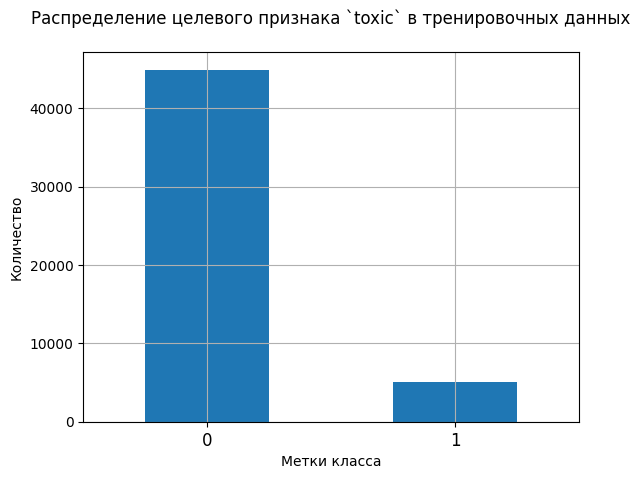

In [15]:
y_train.value_counts().plot(kind='bar',
                            xlabel='Метки класса',
                            ylabel='Количество',
                           grid=True)
plt.gca().tick_params(axis='x', rotation=0, labelsize=12)
plt.gca().set_title('Распределение целевого признака `toxic` в тренировочных данных', pad=20)
plt.show()

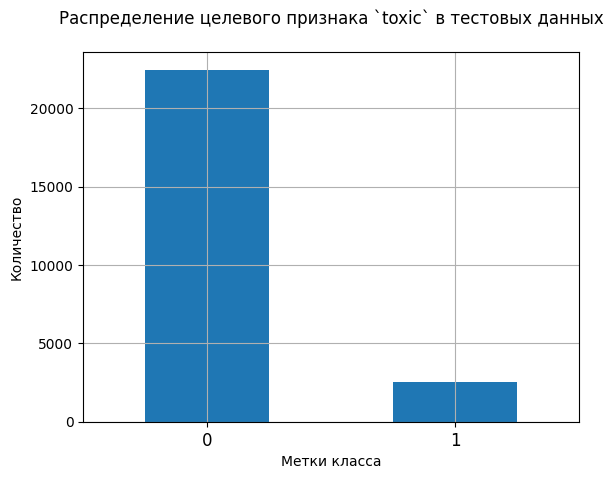

In [16]:
y_test.value_counts().plot(kind='bar',
                            xlabel='Метки класса',
                            ylabel='Количество',
                           grid=True)
plt.gca().tick_params(axis='x', rotation=0, labelsize=12)
plt.gca().set_title('Распределение целевого признака `toxic` в тестовых данных', pad=20)
plt.show()

Для дальнейшего обучения  будем использовать тренировочные данные (X_train, y_train) и  
тестовые данные (X_test, y_test)

## Обучение

Обучим следующие модели:
____
- Логистическая регрессия с векторизацией TF-IDF и лемматизацией с помощью библиотеки spacy:

Корпус текстов будет лемматизирован с использованием библиотеки spacy.
Затем тексты будут преобразованы в векторы с использованием метода TF-IDF.
На этих векторизованных текстах будет обучена модель логистической регрессии.

______
- Логистическая регрессия с векторизацией TF-IDF и лемматизацией с помощью библиотеки nltk:

Корпус текстов будет лемматизирован с использованием библиотеки nltk.
Затем тексты будут преобразованы в векторы с использованием метода TF-IDF.
На этих векторизованных текстах будет обучена модель логистической регрессии.

_______
- Логистическая регрессия, обученная на эмбеддингах BERT:

Тексты будут преобразованы в эмбеддинги с использованием модели BERT.
На этих эмбеддингах будет обучена модель логистической регрессии.

_____
- LGBMClassifier из библиотеки LightGBM, обученная на эмбеддингах BERT:

Тексты будут преобразованы в эмбеддинги с использованием модели BERT.
На этих эмбеддингах будет обучена модель градиентного бустинга LGBMClassifier из библиотеки LightGBM.

_____




### Лемматизация

1.Лемматизируем  тексты, используя две библиотеки:
- spacy;
- nltk.

2. Каждый  из лемматизированных корпусов векторизуем используя метрику TF-IDF.
3. Обучим  модель логистической регрессии на  каждом корпусе и оценим работу каждой модели метрикой F1.
Подбор гиперпараметров  выполним в Grid SearchCV.

Такой подход позволит получить модели заданного ткачества(F1>=0.75) и оценить влияние  лемматизации
на качество модели.

In [24]:
# Функция lemmatize_text лемматизирует  текст, используя модель  spacy'en_core_web_sm' из   spacy
def lemma_text_spacy(text):
    def lemma_extract(doc):# функция  для создания списка с леммами из  списка токенов
        return ' '.join([token.lemma_ for token in doc])


    nlp = spacy.load("en_core_web_sm")    
    
    # Лемматизируем  текст помощью spaсy
    doc = text.apply(lambda x: nlp(x))
    
    s_lemma = doc.apply( lemma_extract)                    
    
    return s_lemma  

In [7]:
# lemma_text_nltk (text)  лемматизирует  текст, используя модель  из библиотеки nltk

# Преобразуем POS теги из pos_tag в ожидаемые WordNetLemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # прилагательное
    elif tag.startswith('V'):
        return 'v'  # глагол
    elif tag.startswith('R'):
        return 'r'  # наречие
    else:
        return 'n'  # существительное (по умолчанию)

# Лемматизация  списка токенов, каждый элемент которого кортеж пример: ('background', 'NN')
# Для преобразования pos_tag в ожидаемые WordNetLemmatizer используем функцию get_wordnet_pos(tag)
def lemma_str(tegg_tokens):
    lemma = ' '.join([lemmatizer.lemmatize(token,get_wordnet_pos(tag)) for token, tag in tegg_tokens])
    return lemma
    
# Финальная функция  лемматтизирующая series  c текстами
def lemma_text_nltk (text):

    global lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Токенизация и проставление pos тегов
    tokens = text.apply(lambda x: word_tokenize(x))
    tagged_tokens = tokens.apply(lambda x:pos_tag(x))
    

    s_lemma = tagged_tokens.apply(lemma_str)
    
    return s_lemma

Лемматизируем  с помощью `spacy` X_train и X_test.

In [ ]:
%%time
X_train_spacy = lemma_text_spacy(X_train)

In [ ]:
%%time
X_test_spacy = lemma_text_spacy(X_test)

________________________________

Лемматизируем с помощью nltk   X_train и X_test.

In [22]:
X_train.dtypes

dtype('O')

In [10]:
%%time
X_train_nltk = lemma_text_nltk(X_train)

CPU times: total: 4min 54s
Wall time: 5min 2s


In [29]:
%%time
X_test_nltk = lemma_text_nltk(X_test)

CPU times: total: 2min 9s
Wall time: 2min 9s


### Векториризация TF-IDF

Рассчитаем TF-IDF для лемматизированных X_train_spacy, X_test_spacy.

In [30]:
nlp = spacy.load("en_core_web_sm")
stop_words =nlp.Defaults.stop_words
stop_words= [word.lower() for word in stop_words]

count_tf_idf = TfidfVectorizer(stop_words = stop_words)

In [31]:
%%time
X_train_spacy_tf_idf = count_tf_idf.fit_transform(X_train_spacy)

CPU times: total: 3.02 s
Wall time: 3.02 s


In [32]:
%%time
X_test_spacy_tf_idf = count_tf_idf.transform(X_test_spacy)

CPU times: total: 1.36 s
Wall time: 1.36 s


_________________________________________________________________________________

Рассчитаем TF-IDF для лемматизированных X_train_nltk, X_test_nltk.

In [33]:
X_train_nltk_tf_idf = count_tf_idf.fit_transform(X_train_nltk)

In [34]:
X_test_nltk_tf_idf = count_tf_idf.transform(X_test_nltk)

### Обучение модели

Воспользуемся GridSEarchCV для  выбора гиперпараметров модели LogisticRegression.  
Предварительно модель была обучена на словаре параметров:
```
 param_model= [{'l1_ratio' : [0,0.2,0.5,0.7,1],
                'C': [0.1,0.5, 1, 10, 20,30] }]
```
На основе полученных параметров для оптимальной модели был сформирован сокращенный словарь параметров для ускорения времени обучения с использованием GridSearchCV.

In [35]:
param_model= [{
               'l1_ratio' : [1],
                'C': [9,10]
}]

In [36]:
grid_search = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE,solver='saga',penalty='elasticnet',max_iter=5000), 
    param_model, 
    cv=3,
    scoring ='f1',
    n_jobs=-1
)

#### Pipeline+OptunaSearch

In [37]:
def make_oscv( model, param):
    
    oscv = OptunaSearchCV(
                          model,
                          param,
                          scoring='f1',
                          n_jobs=-1,
                          cv=3,
                          n_trials=30,
                          random_state=RANDOM_STATE,
                          verbose=False
     )   
    return oscv

Создадим пайплайн pipe_spacy c векторизатором TfidfVectorizer  и моделью  LogisticRegression.

In [69]:

MAX_ITER=1000
pipe_spacy_log = make_pipeline(TfidfVectorizer(stop_words = stop_words),
                               LogisticRegression(random_state=RANDOM_STATE,solver='saga',penalty='elasticnet',max_iter=MAX_ITER))

print(pipe_spacy_log)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['with', 'put', 'really', 'whose',
                                             'thence', 'now', 'n‘t', 'where',
                                             'for', 'that', 'when', 'anything',
                                             'others', 'however', 'once', 'am',
                                             'get', 'fifty', 'seem',
                                             'hereafter', 'or', 'myself',
                                             'being', 'who', 'all', 'nobody',
                                             'then', 'always', 'hers', "'ve", ...])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty='elasticnet',
                                    random_state=50, solver='saga'))])


In [40]:
# Словарь парметров  для Optuna
# ngram_range  [(1, 1), (1, 2), (1, 3)] n-граммы для TfidfVectorizer
param_model_spacy = { 
    
        'logisticregression__l1_ratio': distributions.FloatDistribution(0, 3,step= 0.01),
        'logisticregression__C': distributions.FloatDistribution(0.1, 10, step = 0.01),
         'tfidfvectorizer__ngram_range': distributions.CategoricalDistribution([(1, 1), (1, 2), (1, 3)])
    
}       

In [41]:
oscv_spacy_log = make_oscv (pipe_spacy_log, param_model_spacy)

In [ ]:
%%time
oscv_spacy_log.fit(X_train_spacy, y_train)

In [68]:
oscv_spacy_log

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('tfidfvectorizer',
                                          TfidfVectorizer(stop_words=['with',
                                                                      'put',
                                                                      'really',
                                                                      'whose',
                                                                      'thence',
                                                                      'now',
                                                                      'n‘t',
                                                                      'where',
                                                                      'for',
                                                                      'that',
                                                                      'when',
                                                                      'anything',
                                                                      'others',
                                                                      'however',
                                                                      'once',
                                                                      'am',
                                                                      'get',
                                                                      'fifty',
                                                                      'seem',
                                                                      'hereafter',
                                                                      'or',
                                                                      'myself',
                                                                      'being',
                                                                      'who',
                                                                      'all',
                                                                      'nobody',
                                                                      'then',
                                                                      'always',
                                                                      'hers',
                                                                      "'ve", ...])),
                                         ('logisticregression',
                                          Lo...
                                                             solver='saga'))]),
               n_jobs=-1, n_trials=30,
               param_distributions={'logisticregression__C': FloatDistribution(high=10.0, log=False, low=0.1, step=0.01),
                                    'logisticregression__l1_ratio': FloatDistribution(high=3.0, log=False, low=0.0, step=0.01),
                                    'tfidfvectorizer__ngram_range': CategoricalDistribution(choices=((1, 1), (1, 2), (1, 3)))},
               random_state=50, scoring='f1', verbose=False)

In [70]:
print(f'Параметры лучшей модели:{oscv_spacy_log.best_params_}\n')

print(f'Метрика F1 на  кроссвалидации:{ oscv_spacy_log.best_score_}\n')



Параметры лучшей модели:{'logisticregression__l1_ratio': 0.97, 'logisticregression__C': 2.77, 'tfidfvectorizer__ngram_range': (1, 1)}

Метрика F1 на  кроссвалидации:0.7602752404881823



Обучим и протестируем модель на X_train_spacy_tf_idf и X_test_spacy_tf_idf
(Вектора, полученные на лемматизации spacy)

In [45]:
%%time
grid_search.fit(X_train_spacy_tf_idf, y_train)

CPU times: total: 19min 37s
Wall time: 37min 11s


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=5000, penalty='elasticnet',
                                          random_state=50, solver='saga'),
             n_jobs=-1, param_grid=[{'C': [9, 10], 'l1_ratio': [1]}],
             scoring='f1')

In [46]:
print(f'Параметры лучшей модели:{grid_search.best_params_}\n')

print(f'Метрика F1 на  кроссвалидации:{ grid_search.best_score_}\n')



Параметры лучшей модели:{'C': 10, 'l1_ratio': 1}

Метрика F1 на  кроссвалидации:0.7402639474391504



_________________________________________________________________________________

Обучим и протестируем модель на X_train_nltk_tf_idf и X_test_nltk_tf_idf
(Вектора, полученные на лемматизации nltk)

In [47]:
param_model= [{
        'l1_ratio' : [0.9,1],
        'C': [9,10,11]
}]

In [48]:
grid_search_nltk = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE,solver='saga',penalty='elasticnet',max_iter=5000), 
    param_model, 
    cv=3,
    scoring ='f1',
    n_jobs=-1
)

In [49]:
grid_search_nltk.fit(X_train_nltk_tf_idf, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=5000, penalty='elasticnet',
                                          random_state=50, solver='saga'),
             n_jobs=-1, param_grid=[{'C': [9, 10, 11], 'l1_ratio': [0.9, 1]}],
             scoring='f1')

In [50]:
print(f'Параметры лучшей модели:{grid_search_nltk.best_params_}\n')

print(f'Метрика F1 на  кроссвалидации:{ grid_search_nltk.best_score_}\n')



Параметры лучшей модели:{'C': 9, 'l1_ratio': 1}

Метрика F1 на  кроссвалидации:0.7345587315276507



#### Ембеддинги BERT

Обучим  модель на эмбеддингах, сформированных моделью BERT
Инициализирум токенайзер и модель BERT ('bert_base_uncased')

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model = BertModel.from_pretrained('bert-base-uncased')


Создадим тренировочную и тестовую выборки для нашего проекта. Размеры выборок определим исходя  из разумного времени векторизации текстов. Обработка корпуса из 5000 текстов на моем компьютере занимает примерно 4 часа. Поэтому, для тренировочной выборки мы выберем 5000 текстов, а для тестовой - 2500 текстов.

In [53]:
TRAIN_SIZE = 5000
X=df_comments['text']
y=df_comments['toxic']
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
                X,  y, random_state=RANDOM_STATE, train_size=TRAIN_SIZE, stratify=y)

In [54]:
TEST_SIZE = 2500

X_valid_bert, X_test_bert, y_valid_bert, y_test_bert = train_test_split(X_test, y_test,
                random_state=RANDOM_STATE, test_size=TEST_SIZE, stratify=y_test)

In [55]:
print(f'\nРазмер X_train_bert: {X_train_bert.shape[0]},  y_train_bert: {y_train_bert.shape[0]}')
print(f'\nРазмер X_test_bert: {X_test_bert.shape[0]},  y_test_bert: {y_test_bert.shape[0]}\n')


Размер X_train_bert: 5000,  y_train_bert: 5000

Размер X_test_bert: 2500,  y_test_bert: 2500



Создадим функцию, возвращающую эмбеддинги текстов.

In [ ]:
# batch_embedding - возвращает  объект outputs. содержащий словрь  с эмбеддингами
def batch_embedding (text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", \
                    max_length=512)
    
    
    with torch.no_grad():
        outputs = model(**inputs)
      
    #embedding = outputs[0][:,0,:].numpy()    
    return outputs

Создадим загрузчик батчей и  вычислим эмбеддинги для X_train_bert и X_test_bert. Результат сохраним в списке `embeddings и 'embeddings_test'  


!!! Две следующие ячейки  потребовали  6 часов для выполнения. Полученные результаты были сохранены в облаке.!!!<br>
!!! Проект может быть продолжен как с выполнением этих ячеек, так и без, используя данные  из облака.!!! <br>


In [ ]:
batch_size = 100
embeddings=[]


for i in notebook.tqdm(range(abs(-X_train_bert.shape[0] // batch_size))):
    if (i+1)*batch_size>= X_train_bert.shape[0]:
        end_size = X_train_bert.shape[0]
    else: end_size = (i+1)*batch_size     
    text = X_train_bert.iloc[batch_size*i : end_size].tolist()
    embedding = batch_embedding (text)[0][:,0,:].numpy()
    embeddings.append(embedding)

In [ ]:
batch_size = 100
embeddings_test=[]


for i in notebook.tqdm(range(abs(-X_test_bert.shape[0] // batch_size))):
    if (i+1)*batch_size>= X_test_bert.shape[0]:
        end_size = X_test_bert.shape[0]
    else: end_size = (i+1)*batch_size     
    text = X_test_bert.iloc[batch_size*i : end_size].tolist()
    embedding = batch_embedding (text)[0][:,0,:].numpy()
    embeddings_test.append(embedding)

Соберём эмбеддинги в матрицу признаков:
- для X_train_bert - embedding_train;
- для X_tets_bert - embedding_test

Запишем  полученные матрицы в файлы .csv  и сохраним  их на диске.

In [58]:
try:
    embedding_train = pd.DataFrame (np.vstack(embeddings))
    embedding_test =  pd.DataFrame (np.vstack(embeddings_test))
    #  Код ниже был выполнен при первоначальном расчете эмбеддингов:
    # embedding_train.to_csv('embedding_train.csv', index=False)
    # embedding_test.to_csv('embedding_test.csv', index=False)
except:
    print('Продолжим обучение модели на ранее полученных данных')


Продолжим обучение модели на ранее полученных данных


#### Обучение моделeй на эмбеддингах BERT

Обучим две модели:
- модель LogisticRegression
- модель Модель LGBMClassifier из библиотеки LightGBM.

In [59]:
try:
    X_train_emb = embedding_train
except:    
    url = 'https://drive.google.com/uc?export=download&id=1Yiddxe0UKBRAkLO5DQ1140ptVsoBPQXv'
    X_train_emb =pd.read_csv(url)   


In [60]:
try:
    X_test_emb = embedding_test
except:    
    url_test = 'https://drive.google.com/uc?export=download&id=1jdPyYnpe-cydIaajTaTovcgoZsUDKgZ9'
    X_test_emb =pd.read_csv(url_test)

##### модель LogisticRegression

In [61]:
param_model_bert= [
        # словарь для модели LogisticRegression
       {
       
        'l1_ratio' : [0.2,0.5,0.7],
        'C': [0.3,0.5,0.7]
        }]

In [62]:
grid_search_bert = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE,solver='saga',penalty='elasticnet',max_iter=5000), 
    param_model_bert, 
    cv=3,
    scoring ='f1',
    n_jobs=-1
)

In [63]:
%%time
grid_search_bert.fit(X_train_emb,y_train_bert)

CPU times: total: 1min 38s
Wall time: 10min 15s


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=5000, penalty='elasticnet',
                                          random_state=50, solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.3, 0.5, 0.7], 'l1_ratio': [0.2, 0.5, 0.7]}],
             scoring='f1')

In [64]:
print(f'Параметры лучшей модели:{grid_search_bert.best_params_}\n')

print(f'Метрика F1 на  кроссвалидации:{ grid_search_bert.best_score_}\n')



Параметры лучшей модели:{'C': 0.5, 'l1_ratio': 0.7}

Метрика F1 на  кроссвалидации:0.6793018510760446



__________________

##### модель Модель  LGBMClassifier из библиотеки  LightGBM.

Для подбора гиперпараметров модели LGBMClassifier мы используем метод гиперпараметрической оптимизации OptunaSearchCV. Пример кода и результаты его выполнения приведены ниже.  
В рамках данного проекта, для экономии времени, мы не будем запускать выполнение этого кода, а воспользуемся уже полученными оптимальными гиперпараметрами для обучения модели LGBMClassifier.
(Структура кода взята из моих предыдущих проектов)

```
def make_oscv( model, param):
    
    oscv = OptunaSearchCV(
                          model,
                          param,
                          scoring='f1',
                          n_jobs=-1,
                          cv=3,
                          n_trials=100,
                          random_state=RANDOM_STATE,
                          verbose=False
     )   
    return oscv
param_model_lgbmr = { 
        'learning_rate': distributions.FloatDistribution(0.01, 0.16,step=0.05), # (default=0.1)
        'n_estimators':distributions.IntDistribution(100,1000,step=100), #(default=100)
        'num_leaves': distributions.IntDistribution(50,100, step=5) # default=31
}

model_lgbmr =  LGBMClassifier (boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1)
oscv_lgbmr = make_oscv(model_lgbmr, param_model_lgbmr)
%%time
oscv_lgbmr.fit(X_train_emb, y_train_bert)


```
CPU times: total: 9h 53min 14s
Wall time: 2h 44min 21s
 OptunaSearchCVi
estimator: LGBMClassifier

LGBMClassifier

Параметры лучшей модели:{'learning_rate': 0.16, 'n_estimators': 900, 'num_leaves': 85}

Метрика F1 на  кроссвалидации:0.5912947459868079


In [65]:
model_testing =LGBMClassifier (boosting_type='gbdt',
                               random_state=RANDOM_STATE,
                               learning_rate = 0.16,
                               n_estimators = 900,
                               num_leaves = 85,
                               verbosity=-1)

In [66]:
%%time
model_testing.fit(X_train_emb, y_train_bert)

CPU times: total: 54.5 s
Wall time: 28.4 s


LGBMClassifier(learning_rate=0.16, n_estimators=900, num_leaves=85,
               random_state=50, verbosity=-1)

In [67]:
f1_score(y_test_bert, model_testing.predict(X_test_emb))

0.5813333333333334

##### Тестирование лучшей модели:

In [75]:
print(f'\n Параметры лучшей модели:{oscv_spacy_log.best_params_}\n')

pred_spacy = oscv_spacy_log.predict(X_test_spacy)
print(f'Метрика  F1 на тестовых данных: {f1_score(y_test, pred_spacy):.3f}')


 Параметры лучшей модели:{'logisticregression__l1_ratio': 0.97, 'logisticregression__C': 2.77, 'tfidfvectorizer__ngram_range': (1, 1)}

Метрика  F1 на тестовых данных: 0.762


## Выводы

Для построеня моделей по определению тональности текстов( задача классификации) были использованы два подхода:
1. Обучение  модели логистической регрессиии на  векторизованных текстах, используя алгоритмы TF_IDF
2. Обучение  моделей логистической регрессии и модели градиентного бустинга на ембеддингах, полученных
   с помощью  модели BERT

В рамках первого подхода применили дв способа лемматизации основанных на библиотеках  spacy и nltk.
В результате были подготовлены две тренровочные  и тестовые выборки на которых в дальнейшием после
векторизации обучалась и тестировалась модель логистической регресиии.
В дальнейшем для простоты будем называть выборка spacy  и выборка nltk.

Результаты для модели.обученной  на выборке spacy

Модель LogisticRegression
Параметры лучшей модели:
- C = 2.77, 
- l1_ratio = 0.97
- ngram_range =(1, 1)

Метрика F1 на  кроссвалидации:0.760<br>
Метрика  F1 на тестовых данных: 0.762

**Эта модель соответствует заданному критерию качества, достигнув значения метрики F1 не менее 0.75.**

______
Результаты для модели.обученной  на выборке nltk

Модель LogisticRegression
Параметры лучшей модели:
- C=9,
- l1_ratio=1

Метрика F1 на  кроссвалидации:0.735<br>
Метрика  F1 на тестовых данных: 0.74084




В рамках второго подхода для создания матриц с эмбеддингами мы использовали алгоритм BERT. Этот процесс занял значительное время — более 4 часов. Чтобы избежать повторного выполнения столь длительной операции, результаты были сохранены в облаке. Таким образом, в дальнейшей работе появилась возможность использовать  готовыеэмбеддинги, что позволило существенно сэкономить время.

Результаты для модели LogisticRegression

Параметры лучшей  модели:
- C = 0.5,
- l1_ratio = 0.7
- 
Метрика F1 на  кроссвалидации:0.6793<br>
Метрика  F1 на тестовых данных: 0.653

__________________________________
Результаты для модели LGBMClassifier

Параметры лучшей модели:
- learning_rate = 0.16,
- n_estimators = 900,
- num_leaves = 85

Значение метрики F1 на тестовой выборке: 0.581



1. В целом модели обученные на векторах, полученных с помощью TF_IDF  на метрике  F1  показали  лучшие результаты,  чем модели  обученные с использованием BERT.
2. Целевого значения F1 не менее 0.75 достигла  только  одна модель, обученная  с помощью TF-IDF.
   Лемматизация для этой модели была вополнена средствами библиотеки spacy.
   Модель, лемматизированная  средствами  библиотеки nltk чуть худший результат  F1 =0.741  против 0.754 у модели со spacy,но время  потраченное на лемматизацию  nltk оказалось втрое  меньше.
   Таким образом, можно сделать вывод, что лемматизация средствами библиотеки spacy предпочтительнее, если требуется максимально высокое качество модели. Однако, если приоритетом является время, то можно остановиться на библиотеке nltk.


Модели, обученные на эмбеддингах BERT, показали значительно худшие результаты как по качеству, так и по времени вычисления эмбеддингов. В рамках данной задачи использование подхода, основанного на модели BERT, представляется нецелесообразным.

   